In [1]:
# Code Block 1
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

!pip install text_hammer
import text_hammer as th
import seaborn as sns

from wordcloud import STOPWORDS
from collections import defaultdict

# import tqdm
from tqdm.auto import tqdm
# instantiate tqdm before use 
tqdm.pandas()

!pip install transformers
from transformers import AutoTokenizer,TFBertModel

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

from wordcloud import WordCloud

max_len = 36

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/apps/project/ondemand/app_jupyter/3.0.17/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/apps/project/ondemand/app_jupyter/3.0.17/bin/python -m pip install --upgrade pip' command.


2023-11-30 23:35:38.795977: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 23:35:38.796108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 23:35:38.950139: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 23:35:39.212468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 23:35:43.788359: W tensorflow/comp

In [2]:
# Code Block 2
# load the dataset available in the github in raw format, read only the required columns 
train_data = pd.read_csv('https://raw.githubusercontent.com/raghunandanbhat/Predicting-disaster-tweets-with-BERT/main/Data/train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('https://raw.githubusercontent.com/raghunandanbhat/Predicting-disaster-tweets-with-BERT/main/Data/test.csv',usecols=['id','text'])
#sample_data = pd.read_csv('https://raw.githubusercontent.com/raghunandanbhat/Predicting-disaster-tweets-with-BERT/main/Data/sample_submission.csv')

In [3]:
# Code Block 3
# checking the size of the dataset
print("Shape of Training set:", train_data.shape)
print("Shape of Testing set:", test_data.shape)

Shape of Training set: (7613, 3)
Shape of Testing set: (3263, 2)


In [4]:
# checkout the training dataset
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Code Block 5
# checkout the test dataset
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
from bs4 import BeautifulSoup

def remove_html_tags_with_parser(x):
    return BeautifulSoup(x, 'html.parser').get_text().strip()


In [7]:
# Code Block 6
# text preprocessing to remove special characters, emails, html tags and convert all tweets to lower case
def text_preprocessing(df,col_name):
    df[col_name] = df[col_name].progress_apply(lambda x:str(x).lower())
    df[col_name] = df[col_name].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_emails(x))
    df[col_name] = df[col_name] = df[col_name].progress_apply(lambda x: remove_html_tags_with_parser(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_special_chars(x))
    df[col_name] = df[col_name].progress_apply(lambda x: th.remove_accented_chars(x))
    return(df)

In [8]:
# pre processing text column from the trainging data using the above method
train_cleaned_data = text_preprocessing(train_data,'text')

# Added: pre-processing test data to maintain consistancy 
test_cleaned_data = text_preprocessing(test_data, 'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

  0%|          | 0/3263 [00:00<?, ?it/s]

In [9]:
# checkout the data after pre-processing step
train_cleaned_data.head(10)

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update california hwy 20 closed in b...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,i am on top of the hill and i can see a fire i...,1
8,14,there is an emergency evacuation happening now...,1
9,15,i am afraid that the tornado is coming to our ...,1


In [10]:
# Code Block 9
# making a copy of cleaned tarining  and testing dataset
train_data = train_cleaned_data.copy()

# Added: Making a copy of cleaned test dataset
test_data = test_cleaned_data.copy()

In [11]:
# Code Block 10
# This process is only for visualization. train and test data for model will have stopwords in it
# download the stop words from NLTK and remove stop words from tweets
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')

train_data_vis = train_data.copy()
train_data_vis['text'] = train_data_vis['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
print(train_data_vis.head())

# Edit: Added this code to remove stopwords from the test data to maintain consistency.
test_data_vis = test_data.copy()
print("-----------------------------------------------------------------------")
test_data_vis['text'] = test_data_vis['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
print(test_data_vis.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/PGS0310/neha2611/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   id                                               text  target
0   1       deeds reason earthquake may allah forgive us       1
1   4              forest fire near la ronge sask canada       1
2   5  residents asked shelter place notified officer...       1
3   6  13000 people receive wildfires evacuation orde...       1
4   7  got sent photo ruby alaska smoke wildfires pou...       1
-----------------------------------------------------------------------
   id                                               text
0   0                        happened terrible car crash
1   2  heard earthquake different cities stay safe ev...
2   3  forest fire spot pond geese fleeing across str...
3   9              apocalypse lighting spokane wildfires
4  11             typhoon soudelor kills 28 china taiwan


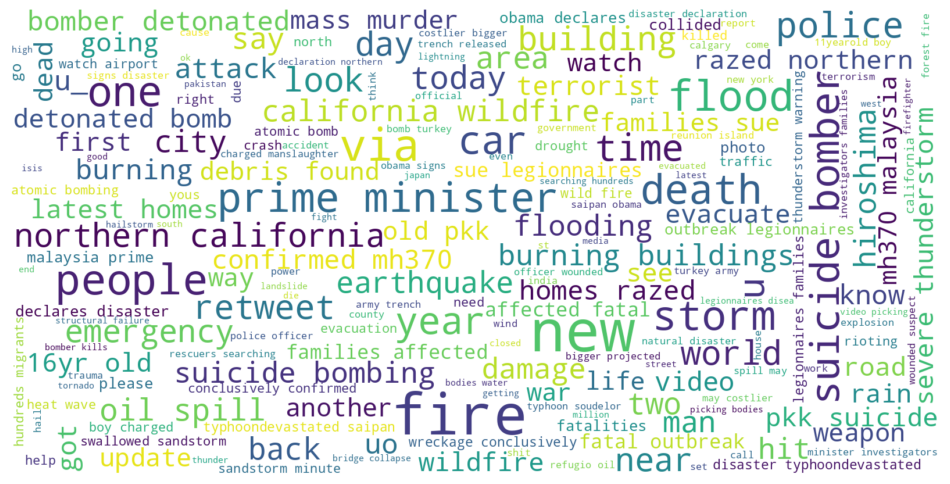

In [12]:
# Code Block 11
# Visualizing the dataset using Word Cloud after removing stopwords
# Filter all the disaster tweeets
disaster_tweets = train_data_vis[train_data_vis.target == 1]
disaster_string = list(map(lambda x: x, disaster_tweets.text))
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')

# generate the word cloud from strings in disaster tweets 
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)

# plot the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

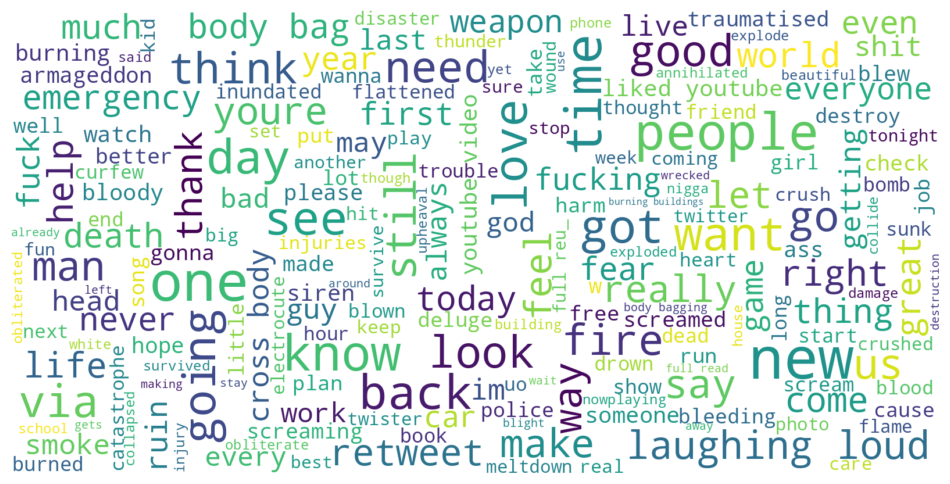

In [13]:
# Code Block 12
# Word cloud for tweets which are not disaster related 

# extract the tweets which are not realted to disaster
formal_tweets = train_data_vis[train_data_vis.target == 0]
formal_string = list(map(lambda x: x, formal_tweets.text))
formal_string = pd.Series(formal_string).str.cat(sep=' ')

# create a world cloud using the strins
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)

# plot the word cloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

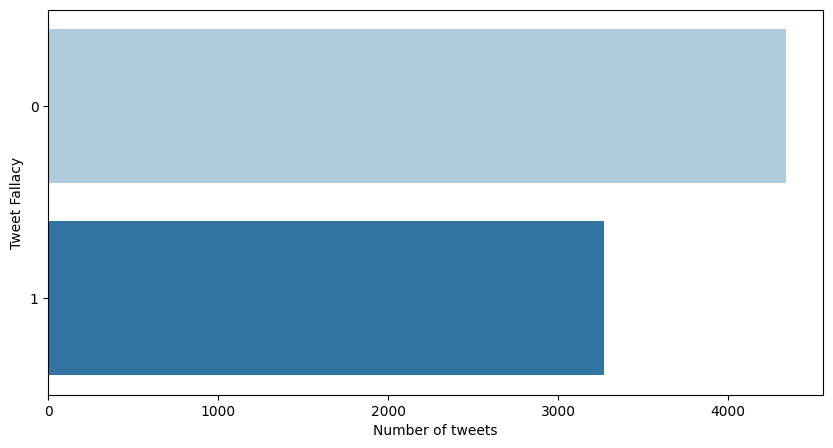

In [14]:
# Code Block 13
#Visualizing class distribution 
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = train_data_vis,palette="Paired")
plt.ylabel("Tweet Fallacy")
plt.xlabel("Number of tweets")
plt.show()

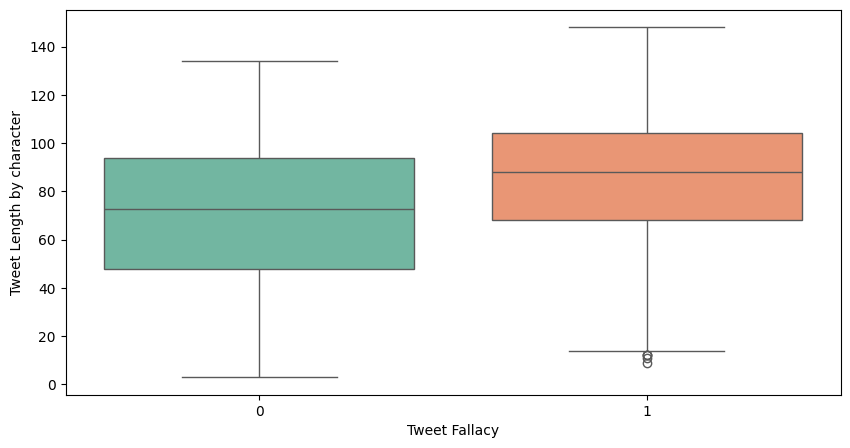

In [15]:
# Code Block 14
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data_vis['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data_vis,palette="Set2")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet Length by character")
plt.show()

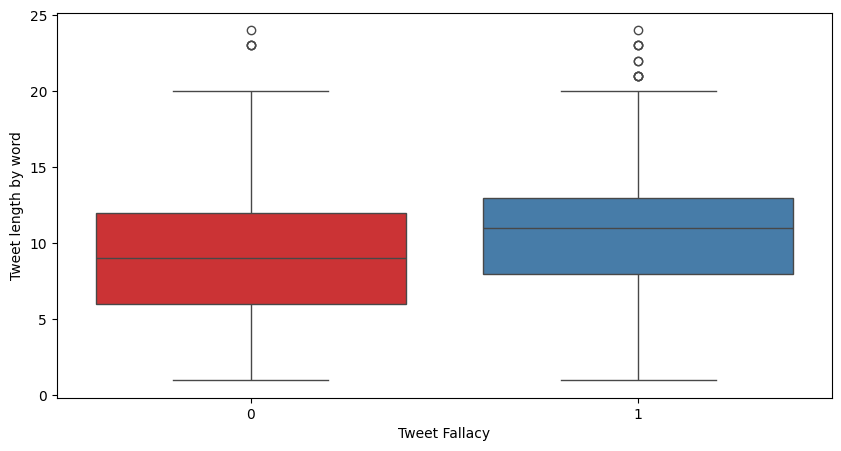

In [16]:
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data_vis['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data_vis,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

In [17]:
# Code Block 16
# word_count
train_data_vis['word_count'] = train_data_vis['text'].apply(lambda x: len(str(x).split()))
test_data_vis['word_count'] = test_data_vis['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data_vis['unique_word_count'] = train_data_vis['text'].apply(lambda x: len(set(str(x).split())))
test_data_vis['unique_word_count'] = test_data_vis['text'].apply(lambda x: len(set(str(x).split())))

# Commented: Stop words and URLs alread removed, no point in calculating their frequencies

# # stop_word_count
# train_data_vis['stop_word_count'] = train_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
# test_data_vis['stop_word_count'] = test_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# # url_count
# train_data_vis['url_count'] = train_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
# test_data_vis['url_count'] = test_data_vis['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data_vis['mean_word_length'] = train_data_vis['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data_vis['mean_word_length'] = test_data_vis['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data_vis['char_count'] = train_data_vis['text'].apply(lambda x: len(str(x)))
test_data_vis['char_count'] = test_data_vis['text'].apply(lambda x: len(str(x)))

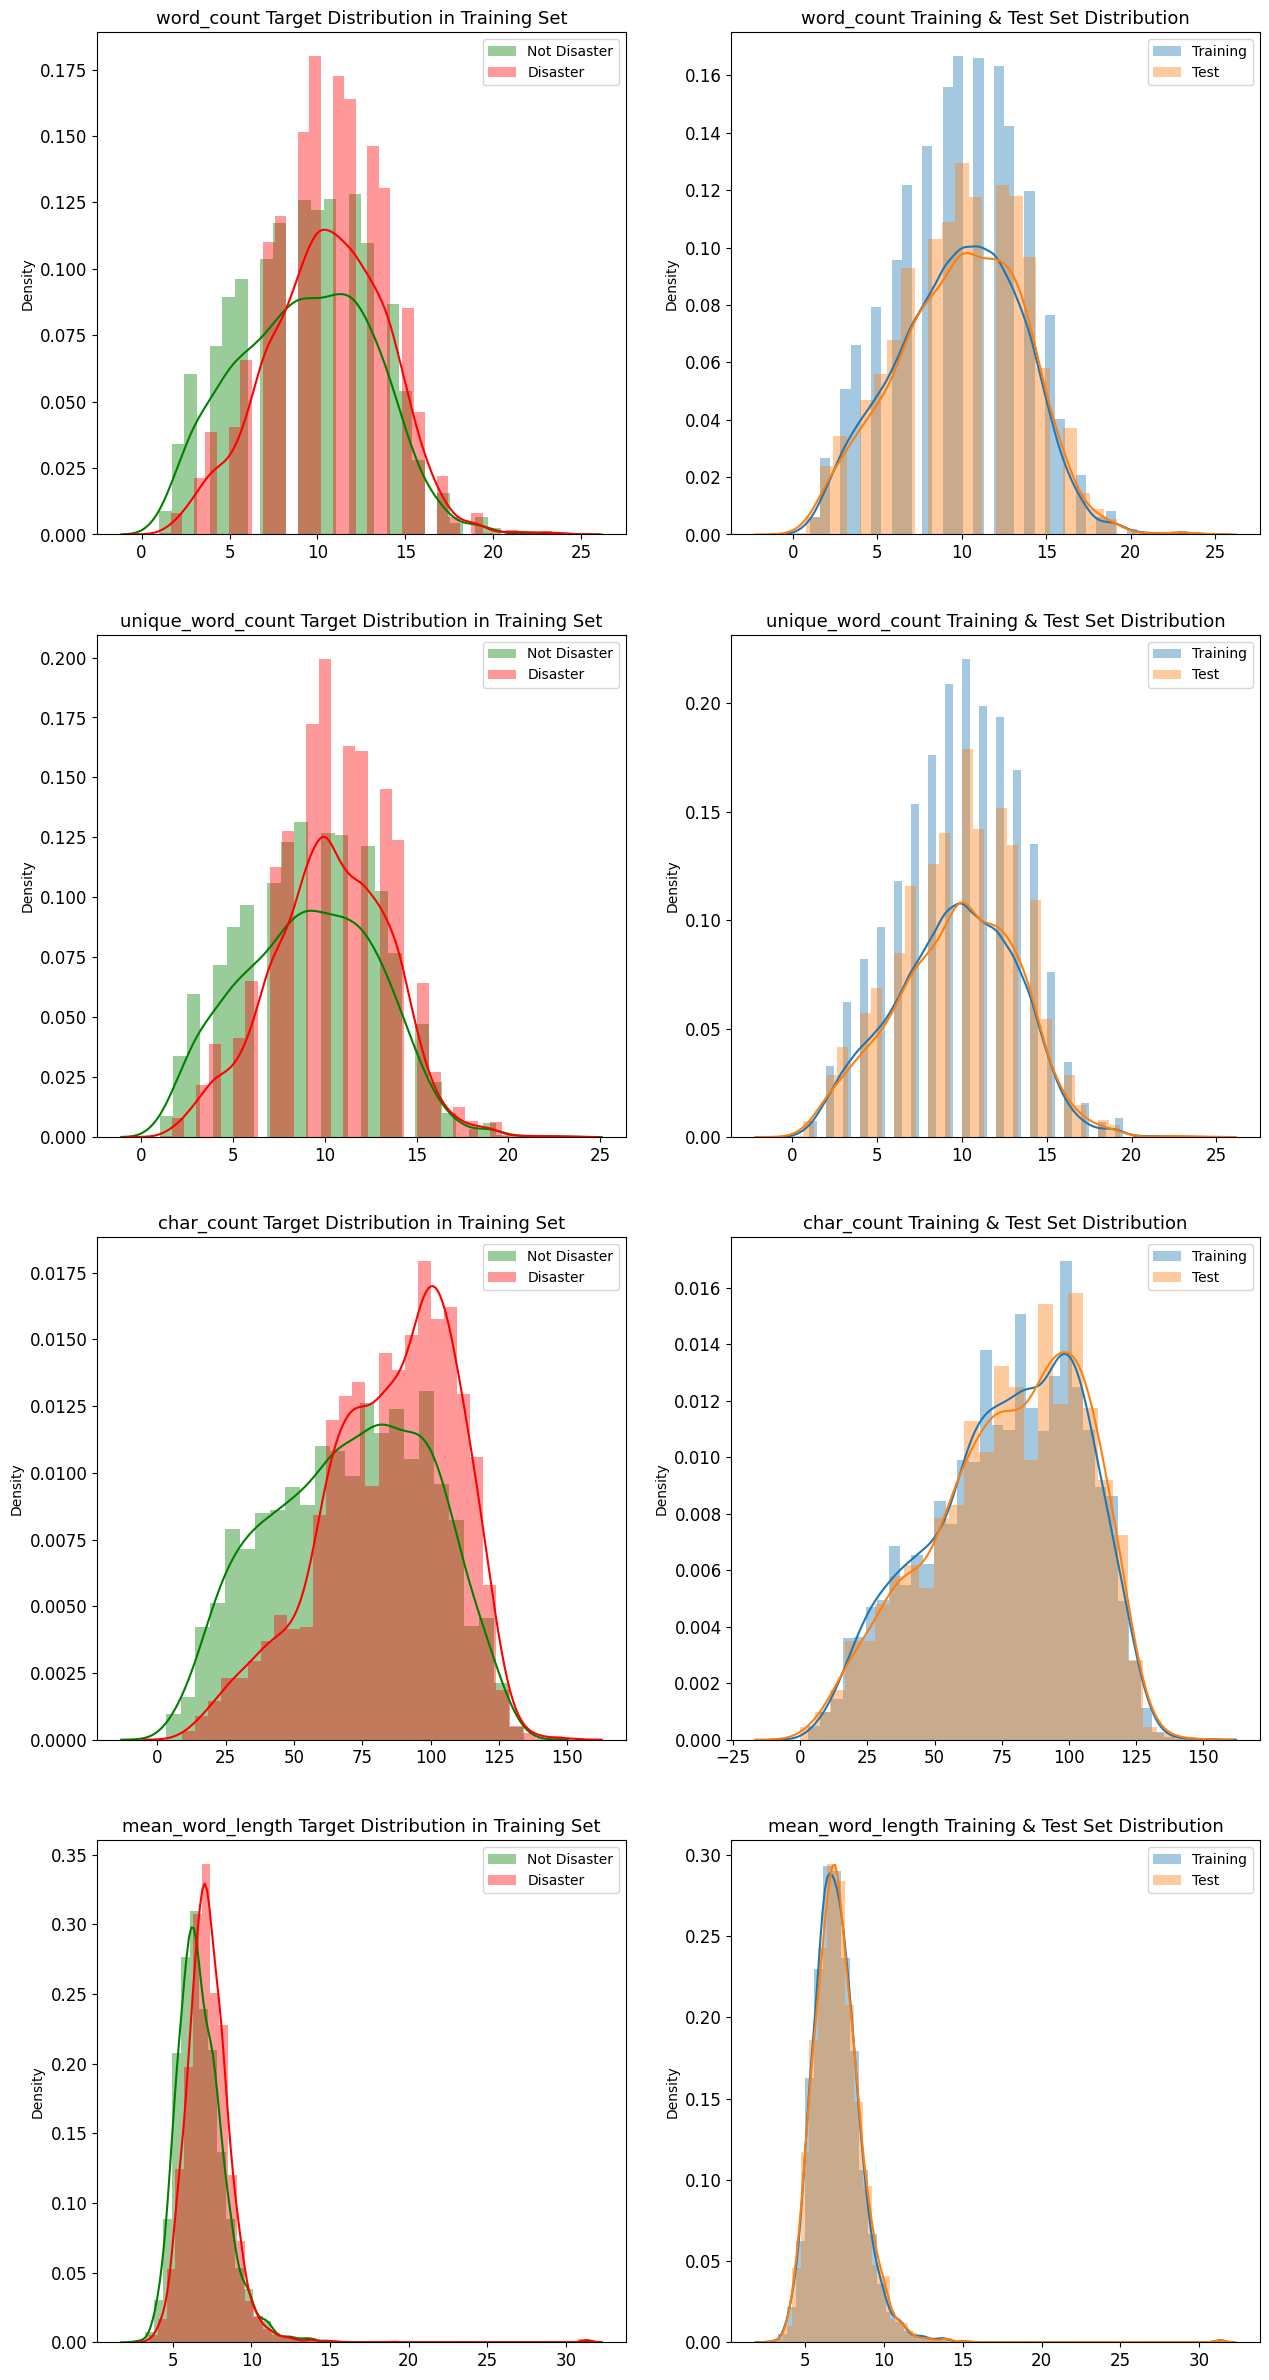

In [18]:
# Code Block 17
METAFEATURES = ['word_count', 'unique_word_count', 'char_count', 'mean_word_length']
DISASTER_TWEETS = train_data_vis['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(15, 30), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data_vis.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_data_vis.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_data_vis[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data_vis[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

In [19]:
# Code Block 18
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [20]:
# Code Block 19
# Testing the Tokenizer
test_token = tokenizer('Happy learning and keep kaggling &*&*&&')
print(type(test_token))
print(test_token)

<class 'transformers.tokenization_utils_base.BatchEncoding'>
{'input_ids': [101, 3407, 4083, 1998, 2562, 10556, 13871, 2989, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [21]:
print("Maximum length of tweets:",max([len(x.split()) for x in train_data.text]))
max_length = 36

Maximum length of tweets: 35


In [22]:
# Code Block 21
x_train = tokenizer(
                    text=train_data.text.tolist(),
                    add_special_tokens=True,
                    max_length=36,
                    truncation=True,
                    padding=True, 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True
                   )

x_train

{'input_ids': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  2683, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [23]:
print("Shape of input token ids:", x_train['input_ids'].shape)
print("Shape of atteniton mask:", x_train['attention_mask'].shape)

Shape of input token ids: (7613, 36)
Shape of atteniton mask: (7613, 36)


In [24]:
y_train = train_data.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [25]:
x_train['input_ids']

<tf.Tensor: shape=(7613, 36), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 23290,  2683, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]], dtype=int32)>

In [26]:
# Code Block 24
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)

out = tf.keras.layers.Dropout(0.1)(embeddings)

out = Dense(128, activation='relu')(out)

out = tf.keras.layers.Dropout(0.1)(out)

out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 36)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 36)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   3351418   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   88         'attention_mask[0][0]']      
                             hidden_state=(None, 36, 10                                       

In [28]:
# Code Block 26
# optimizer for the model
model_optimizer = Adam(
                        learning_rate=6e-06, # this learning rate is for bert model.
                        epsilon=1e-08,
                        clipnorm=1.0
                      )

# Set loss and metrics
model_loss = BinaryCrossentropy(from_logits = True)
model_accuracy = BinaryAccuracy('accuracy')

# Compile the model
model.compile(
              optimizer=model_optimizer,
              loss=model_loss, 
              metrics=model_accuracy
             )

In [29]:
# Code Block 27
# Plot the model layers 
plot_model(model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
# training the model
final = model.fit(
                  x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']},
                  y = y_train,
                  validation_split=0.1,
                  epochs=5,
                  batch_size=32
                 )

Epoch 1/5
215/215 [==============================] - 737s 3s/step - loss: 0.5198 - accuracy: 0.7514 - val_loss: 0.3789 - val_accuracy: 0.8504
Epoch 2/5
215/215 [==============================] - 670s 3s/step - loss: 0.3811 - accuracy: 0.8445 - val_loss: 0.3830 - val_accuracy: 0.8517
Epoch 3/5
215/215 [==============================] - 672s 3s/step - loss: 0.3301 - accuracy: 0.8732 - val_loss: 0.3752 - val_accuracy: 0.8530
Epoch 4/5
215/215 [==============================] - 677s 3s/step - loss: 0.2872 - accuracy: 0.8932 - val_loss: 0.4408 - val_accuracy: 0.8491
Epoch 5/5
215/215 [==============================] - 685s 3s/step - loss: 0.2363 - accuracy: 0.9130 - val_loss: 0.5462 - val_accuracy: 0.8215


In [42]:
accuracy = final.history['accuracy'][-1]  # Last accuracy value during training
print(f"Accuracy: {accuracy}")

Accuracy: 0.9130054116249084


In [64]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [109]:
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout

# Preprocess the data
train_data.dropna(subset=['text', 'target'], inplace=True)
train_data['target'] = train_data['target'].astype(int)

# Split the data into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Load a pre-trained SBERT model
sbert_model = SentenceTransformer('paraphrase-distilroberta-base-v1')

# Encode sentences to get sentence embeddings
X_train = sbert_model.encode(train_data['text'].tolist())
X_val = sbert_model.encode(val_data['text'].tolist())
X_test = sbert_model.encode(test_data['text'].tolist())

# Build a similar neural network model
input_layer = Input(shape=(768,), name="sentence_embeddings")
out = Dropout(0.1)(input_layer)
out = Dense(128, activation='relu')(out)
out = Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
output_layer = Dense(1, activation='sigmoid')(out)

model1 = Model(inputs=input_layer, outputs=output_layer)
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [110]:
model1.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sentence_embeddings (Input  [(None, 768)]             0         
 Layer)                                                          
                                                                 
 dropout_217 (Dropout)       (None, 768)               0         
                                                                 
 dense_47 (Dense)            (None, 128)               98432     
                                                                 
 dropout_218 (Dropout)       (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 32)                4128      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                          

In [111]:
# Train the model
model1.fit(X_train, train_data['target'], epochs=5, batch_size=32, validation_data=(X_val, val_data['target']))


Epoch 1/5
7/7 [==============================] - 1s 29ms/step - loss: 0.6816 - accuracy: 0.5613 - val_loss: 0.6251 - val_accuracy: 0.6981
Epoch 2/5
7/7 [==============================] - 0s 9ms/step - loss: 0.5317 - accuracy: 0.8538 - val_loss: 0.5447 - val_accuracy: 0.7547
Epoch 3/5
7/7 [==============================] - 0s 9ms/step - loss: 0.4231 - accuracy: 0.8962 - val_loss: 0.4668 - val_accuracy: 0.8113
Epoch 4/5
7/7 [==============================] - 0s 10ms/step - loss: 0.3304 - accuracy: 0.9009 - val_loss: 0.4284 - val_accuracy: 0.8302
Epoch 5/5
7/7 [==============================] - 0s 9ms/step - loss: 0.2593 - accuracy: 0.9340 - val_loss: 0.4124 - val_accuracy: 0.8302


In [112]:
val_loss, val_accuracy = model1.evaluate(X_val, val_data['target'])
print(f"Validation Accuracy: {val_accuracy}")

# Predict the labels for the test set
predictions = model1.predict(X_test)
predictions_binary = [1 if pred >= 0.5 else 0 for pred in predictions]

# Save predictions to a CSV file
test_data['target'] = predictions_binary
test_data[['id', 'target']].to_csv('predictions.csv', index=False)

2/2 [==============================] - 0s 8ms/step - loss: 0.4124 - accuracy: 0.8302
Validation Accuracy: 0.8301886916160583
102/102 [==============================] - 0s 2ms/step


In [31]:
def visual_accuracy_and_loss(final):
    acc = final.history['accuracy']
    loss = final.history['loss']

    epochs_plot = np.arange(1, len(loss) + 1)
    
    plt.clf()
    plt.plot(epochs_plot, acc, 'r', label='Accuracy')
    plt.plot(epochs_plot, loss, 'b:', label='Loss')
    plt.title('VISUALIZATION OF LOSS AND ACCURACY CURVE')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

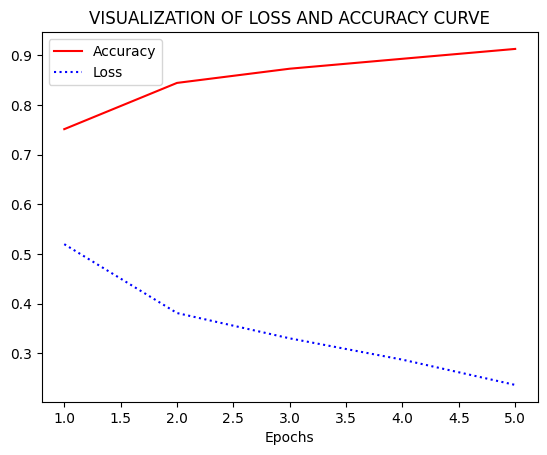

In [32]:
visual_accuracy_and_loss(final)

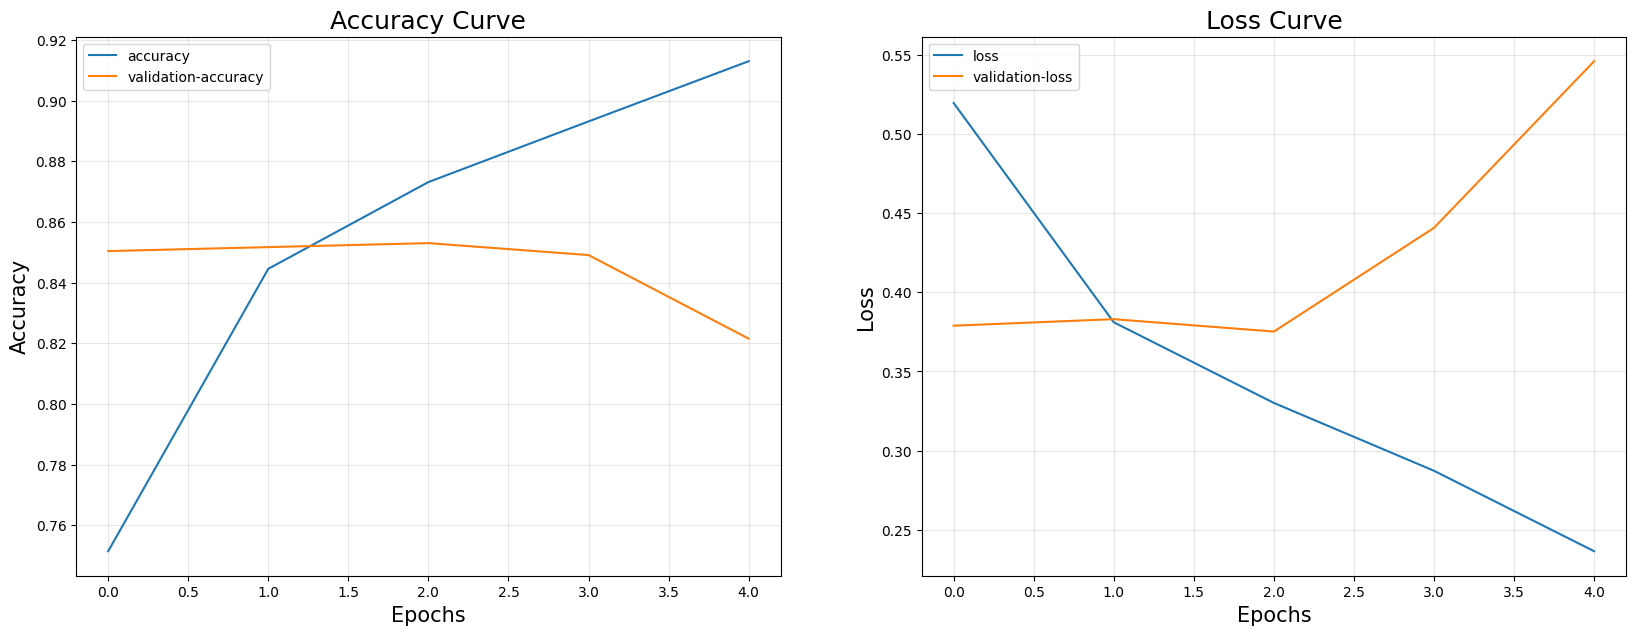

In [33]:
# Code Block 31
# Plot the loss and accuracy curves  

#Defining Figure
f = plt.figure(figsize=(20,7))

#Adding Subplot 1 (For Accuracy)
f.add_subplot(121)

plt.plot(final.epoch, final.history['accuracy'], label="accuracy") # Accuracy curve 
plt.plot(final.epoch, final.history['val_accuracy'], label="validation-accuracy")

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

#Adding Subplot 1 (For Loss)
f.add_subplot(122)

plt.plot(final.epoch, final.history['loss'], label="loss") # Loss curve 
plt.plot(final.epoch, final.history['val_loss'], label="validation-loss")

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()


In [34]:
x_test = tokenizer(
                    text=test_data.text.tolist(),
                    add_special_tokens=True,
                    max_length=36,
                    truncation=True,
                    padding=True, 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True
                  )

In [35]:
# predict
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted

102/102 [==============================] - 98s 916ms/step


array([[0.99513614],
       [0.997017  ],
       [0.9959198 ],
       ...,
       [0.99664503],
       [0.99601287],
       [0.99711967]], dtype=float32)

In [36]:
# convert the decimal prediction values to either 0 or 1
y_predicted = np.where(predicted>0.5,1,0)
y_predicted

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [40]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [37]:
# Code Block 35
# Reshape and attach the predicted values to test dataframe

y_predicted = y_predicted.reshape((1,3263))[0]

test_data['predicted_target'] = y_predicted

print("Prediction on Test data")
print("Number of Disaster Tweets: ", test_data.predicted_target.value_counts()[1])
print("Number of Non-Disaster Tweets: ", test_data.predicted_target.value_counts()[0])

Prediction on Test data
Number of Disaster Tweets:  1491
Number of Non-Disaster Tweets:  1772


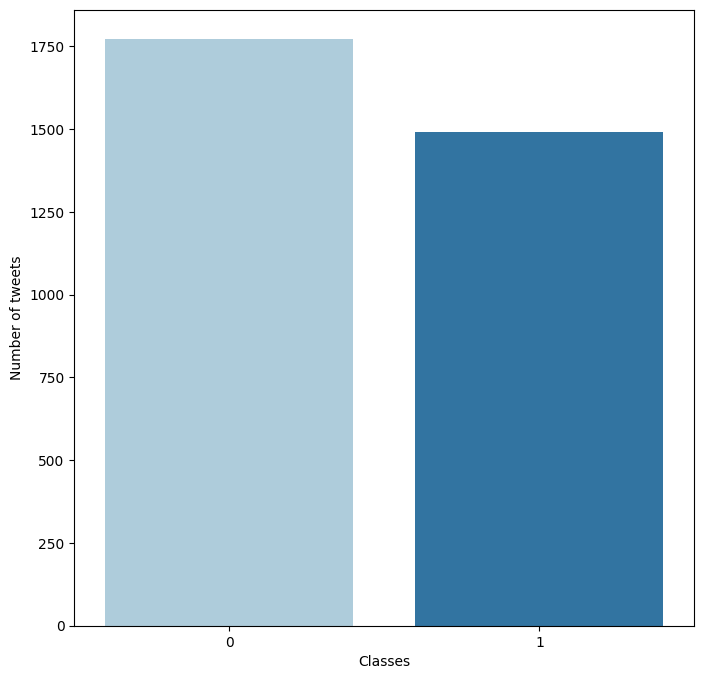

In [38]:
# Code Block 36
# sample_data.to_csv('submission.csv',index = False)
plt.figure(figsize=(8, 8))
sns.countplot(x='predicted_target',data = test_data,palette="Paired")

plt.xlabel("Classes")
plt.ylabel("Number of tweets")
plt.show()

In [39]:
# Code Block 37
# Test a random tweet

# Replace the tweet with any tweet you like and run this block
tweet = "ChatGPT is scary"

tokenized_tweet = tokenizer(
                    text=tweet,
                    max_length=36,
                    truncation=False,
                    padding='max_length', 
                    return_tensors='tf',
                    return_token_type_ids = False,
                    return_attention_mask = True,
                    verbose = True
                  )

prediction = model.predict({'input_ids':tokenized_tweet['input_ids'],'attention_mask':tokenized_tweet['attention_mask']})

if (prediction > 0.5):
  print("Disaster!")
else:
  print("Not a Disaster")

1/1 [==============================] - 0s 212ms/step
Not a Disaster
